**El actual experimento consta de poner a prueba una CNN (Convolutional Neural Network) en el contexto de la predicción multimodal.**

DISCLAIMER: LA EJECUCÓN DE ESTE CÓDIGO FUE EN COLAB, EN LA MAQUINA VIRTUAL DIÓ RESULTADOS DISTINTOS

Entorno en el cual se ejecutó el código.

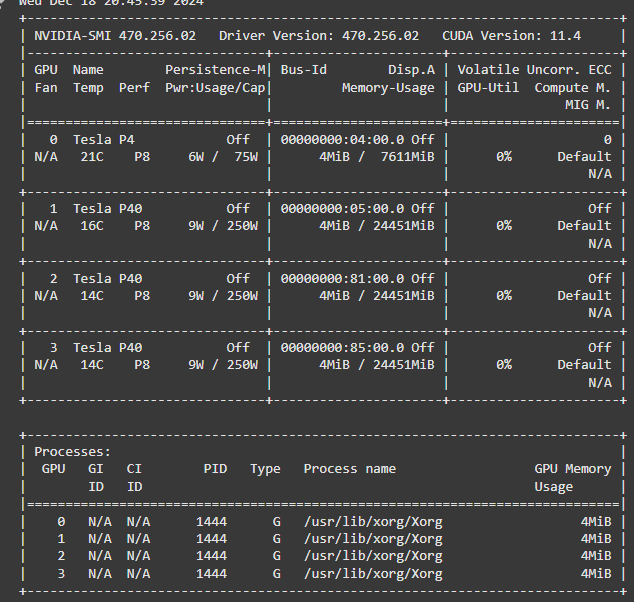

#Imports, set de datos de entrenamiento y testeo y pesos de los modelos ya entrenados

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf

from tensorflow.keras.models import load_model, Model
from tensorflow.keras.applications import VGG16, ResNet50, Xception, NASNetLarge, EfficientNetB7, InceptionV3, InceptionResNetV2, MobileNet
from tensorflow.keras.layers import Flatten, Dense, Input, Dropout, BatchNormalization, concatenate, Reshape, Add, Conv2D, Lambda, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

from PIL import Image

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler


In [7]:
!gdown 1oxyxG9tO_NXEmzxNFM49wPLE3QIAkl8C#dataset
!gdown 1yH7slGrg92hZCIeQZyOrp5oIb_CB_F7l#pesos
!mkdir filesy
!mkdir pesos
!unzip sets_datos.zip -d files
!unzip pesos.zip -d pesos

x_test_conv = np.load("files/x_test.npy")
x_train_conv = np.load("files/x_train.npy")
y_train = np.load("files/y_train.npy")
y_test = np.load("files/y_test.npy")
y_train_original_scale = np.load("files/y_train_original_scale.npy")
y_test_original_scale = np.load("files/y_test_original_scale.npy")

Downloading...
From (original): https://drive.google.com/uc?id=1oxyxG9tO_NXEmzxNFM49wPLE3QIAkl8C#dataset
From (redirected): https://drive.google.com/uc?id=1oxyxG9tO_NXEmzxNFM49wPLE3QIAkl8C&confirm=t&uuid=f82af2af-b320-49ba-8ca7-1d343aa744ea
To: /content/sets_datos.zip
100% 9.41M/9.41M [00:00<00:00, 23.4MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1yH7slGrg92hZCIeQZyOrp5oIb_CB_F7l#pesos
From (redirected): https://drive.google.com/uc?id=1yH7slGrg92hZCIeQZyOrp5oIb_CB_F7l&confirm=t&uuid=defc9498-8eee-4487-8fd4-da64d1277845
To: /content/pesos.zip
100% 294M/294M [00:05<00:00, 52.3MB/s]
mkdir: cannot create directory ‘files’: File exists
mkdir: cannot create directory ‘pesos’: File exists
Archive:  sets_datos.zip
replace files/sat.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: files/sat.png           
replace files/y_test.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: files/y_test.npy        
replace files/y_train.npy? [y]es, [n]o, [A]ll, [N]one, 

Imagen satelital y creación del conjunto de set de datos X con imágenes repetidas

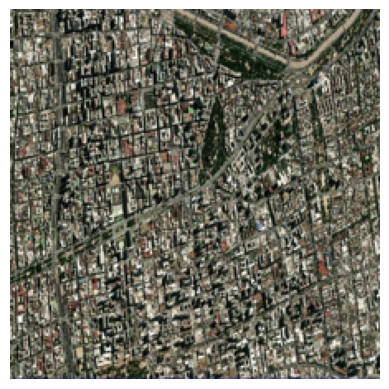

shape de x_train: (1306, 224, 224, 3)
shape de x_test: (272, 224, 224, 3)
shape de y_train: (1306, 1, 44, 15, 1)
shape de y_test: (272, 1, 44, 15, 1)


In [8]:
# Ruta del archivo de la imagen
file_path = 'files/sat.png'

# Abrir la imagen
img = Image.open(file_path)

# Convertir la imagen a RGB
img = img.convert('RGB')

# Cambiar el tamaño de la imagen a 224x224 píxeles
img_resized = img.resize((224, 224))

# Guardar la imagen redimensionada en RGB
img_resized.save('sat_resized_rgb.png')

# Cargar la imagen en RGB
imgg = mpimg.imread('sat_resized_rgb.png')

# Mostrar la imagen en RGB
plt.imshow(imgg)
plt.axis('off')  # Ocultar ejes
plt.show()

# Aplanar la imagen (224x224x3) a (224*224*3,)
imgg_flattened = imgg.reshape(-1, 1)

# Aplicar MinMaxScaler para escalar entre 0 y 1
scaler = MinMaxScaler(feature_range=(0, 1))
imgg_scaled = scaler.fit_transform(imgg_flattened)

# Volver a dar forma a la imagen a su tamaño original (224, 224, 3)
imgg_scaled = imgg_scaled.reshape(224, 224, 3)

# Crear x_train con 1294 copias de la imagen
x_train_cnn = np.array([imgg for _ in range(1306)])

# Crear x_test con 260 copias de la imagen
x_test_cnn = np.array([imgg for _ in range(272)])

# Verificar las formas de los conjuntos de datos
print("shape de x_train:", x_train_cnn.shape)
print("shape de x_test:", x_test_cnn.shape)
print("shape de y_train:", y_train.shape)
print("shape de y_test:", y_test.shape)


#CNN


Se declaran las funciones para crear cualquier CNN, para entrenar y evaluarlo y finalmente para graficar el loss history.

In [9]:
# Valores fijos
num_classes = 44 * 15
input_shape = (224, 224, 3)

# Función para crear el modelo basado en diferentes arquitecturas
def create_model(base_model_func):
    base_model = base_model_func(weights=None, include_top=False, input_tensor=Input(shape=input_shape))

    # Congelar todas las capas del modelo base
    base_model.trainable = False

    x = base_model.output
    x = Flatten()(x)

    x = Dense(2048, activation='relu')(x)


    output_tensor = Dense(num_classes, activation='linear')(x)
    output_tensor = Reshape((1, 44, 15, 1))(output_tensor)

    model = Model(inputs=base_model.input, outputs=output_tensor)

    # Modificación de la compilación solo con pérdida (sin métricas)
    model.compile(optimizer=Adam(learning_rate=0.0002), loss='mean_squared_error')
    return model

# Función para entrenar y evaluar el modelo
def train_and_evaluate(model, x_train, y_train, x_test, y_test):
    early_stopping = EarlyStopping(monitor="val_loss", patience=7)
    reduce_lr = ReduceLROnPlateau(monitor="val_loss", patience=5, factor=0.5, min_lr=1e-6)

    start_time = time.time()
    history = model.fit(
        x_train,
        y_train,
        batch_size=16,
        epochs=50,
        validation_data=(x_test, y_test),
        callbacks=[early_stopping, reduce_lr],
    )
    training_time = time.time() - start_time

    # Evaluación del modelo
    test_loss = model.evaluate(x_test, y_test)
    train_loss = model.evaluate(x_train, y_train)
    minutes_time = training_time / 60
    print(f'Test Loss: {test_loss}')
    print(f'Train Loss: {train_loss}')
    print(f'Training Time: {minutes_time:.1f} minutes')

    return history, test_loss, minutes_time

# Gráfico de la historia de entrenamiento (pérdida)
def plot_history(history):
    epochs = range(1, len(history.history['loss']) + 1)

    plt.figure(figsize=(12, 5))

    # Gráfico de la pérdida
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], 'bo-', label='Pérdida de Entrenamiento')
    plt.plot(epochs, history.history['val_loss'], 'ro-', label='Pérdida de Validación')
    plt.title('Pérdida de Entrenamiento y Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()

    # Gráfico opcional si se utilizan métricas en el futuro (removido MSE del código)
    plt.tight_layout()
    plt.show()


In [10]:
# InceptionV3
model_inceptionv3 = create_model(InceptionV3)
history_inceptionv3, test_loss_inceptionv3, training_time_inceptionv3 = train_and_evaluate(model_inceptionv3, x_train_cnn, y_train, x_test_cnn, y_test)
#model_xception.save_weights('pesos/pesos_xception.h5')
#model_xception.load_weights('pesos/pesos_xception.h5')

Epoch 1/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 35s 228ms/step - loss: 0.0208 - val_loss: 0.0043 - learning_rate: 2.0000e-04
Epoch 2/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 18s 64ms/step - loss: 0.0027 - val_loss: 0.0040 - learning_rate: 2.0000e-04
Epoch 3/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - loss: 0.0026 - val_loss: 0.0039 - learning_rate: 2.0000e-04
Epoch 4/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - loss: 0.0027 - val_loss: 0.0039 - learning_rate: 2.0000e-04
Epoch 5/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - loss: 0.0026 - val_loss: 0.0040 - learning_rate: 2.0000e-04
Epoch 6/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - loss: 0.0026 - val_loss: 0.0039 - learning_rate: 2.0000e-04
Epoch 7/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 0.0026 - val_loss: 0.0040 - learning_rate: 2.0000e-04
Epoch 8/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 0.0026 - val_loss: 0.0039 - learning_rate: 2.0000e-04
Epoch 9/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - loss: 0.0026 - val_loss: 0.0040 - le

#HexConvLSTM

In [11]:
# Define the hexagonal kernel
class HexConstGrid5x3(tf.keras.constraints.Constraint):
    def __init__(self):
        super().__init__()

    def __call__(self, w):
        '''
        [[0, 1, 0],
         [1, 0, 1],
         [0, 1, 0],
         [1, 0, 1],
         [0, 1, 0]]

        '''


        hexaconst=np.ones(w.shape,dtype=np.float32)
        hexaconst[0,0,:,:]=0.0
        hexaconst[0,2,:,:]=0.0
        hexaconst[1,1,:,:]=0.0
        hexaconst[2,0,:,:]=0.0
        hexaconst[2,2,:,:]=0.0
        hexaconst[3,1,:,:]=0.0
        hexaconst[4,0,:,:]=0.0
        hexaconst[4,2,:,:]=0.0

        return w*hexaconst

In [12]:
inp = layers.Input(shape=(None, *x_train_conv.shape[2:]))

# ConvLSTM2D layer
x = layers.ConvLSTM2D(
    filters=128,
    kernel_size=(5, 3),
    padding="same",
    return_sequences=False,
    activation="relu",
    kernel_constraint=HexConstGrid5x3()
)(inp)

x = layers.BatchNormalization()(x)

# Conv2D layer
x = layers.Conv2D(
    filters=1,
    kernel_size=(3, 3),
    activation="relu",
    padding="same"
)(x)

x = layers.Reshape((1,44,15,1))(x)
# Building the complete model
model_conv_lstm  = Model(inp, x)
model_conv_lstm.compile(
    loss='mse',
    optimizer=Adam()
)

model_conv_lstm.summary()

# Define some callbacks to improve training.
early_stopping = EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 50
batch_size = 64

# Fit the model to the training data.
#model_conv_lstm.fit(
#     x_train_conv,#input
#     y_train,#output
#     batch_size=batch_size,
#     epochs=epochs,
#     validation_data=(x_test_conv, y_test),
#     callbacks=[early_stopping, reduce_lr],
#)
#cargar los pesos
model_conv_lstm.load_weights('pesos/pesos_convLSTM.h5')

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, None, 44, 15, 1)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d (ConvLSTM2D)             │ (None, 44, 15, 128)         │         991,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_188              │ (None, 44, 15, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_188 (Conv2D)                  │ (None, 44, 15, 1)           │           1,153 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_2 (Reshape)                  │ (None, 1, 44, 15, 1)        │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 992,897 (3.79 MB)

 Trainable params: 992,641 (3.79 MB)

 Non-trainable params: 256 (1.00 KB)

#Multicolumn CNN y HexConvLSTM

In [19]:
print(f"x_train_cnn shape: {x_train_cnn.shape}")
print(f"x_test_cnn shape: {x_test_cnn.shape}")

print(f"\nx_train_conv shape: {x_train_conv.shape}")
print(f"x_test_conv shape: {x_test_conv.shape}")

print(f"\ny_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

x_train_cnn shape: (1306, 224, 224, 3)
x_test_cnn shape: (272, 224, 224, 3)

x_train_conv shape: (1306, 12, 44, 15, 1)
x_test_conv shape: (272, 12, 44, 15, 1)

y_train shape: (1306, 1, 44, 15, 1)
y_test shape: (272, 1, 44, 15, 1)


In [16]:
# Congelar los pesos de la rama de ConvLSTM
for layer in model_conv_lstm.layers:
    layer.trainable = False


# Escalar la salida de Xception y agregar una constante para ajuste
inceptionv3_output = model_inceptionv3.output

# Mantener la salida de ConvLSTM sin constantes adicionales, ya que tiene mejor `loss`
conv_lstm_output = model_conv_lstm.output  # Sin cambios

# Sumar las salidas de los modelos
merged_output = Add()([inceptionv3_output, conv_lstm_output])
#merged_output = nasnetlarge_output conv_lstm_output

# Reshape a la forma original de salida
final_output = Reshape((1, 44, 15, 1))(merged_output)

# Crear el modelo final
multi_column_model = Model(inputs=[model_inceptionv3.input, model_conv_lstm.input], outputs=final_output)

# Compilar el modelo
multi_column_model.compile(optimizer=Adam(learning_rate=0.0002), loss='mean_squared_error')

# Entrenar el modelo
start_time = time.time()
multi_column_model.fit(
    [x_train_cnn, x_train_conv],
    y_train,
    batch_size=16,
    epochs=13, #se ponen 13 para hacerlo más rapido, pero tienen que ir 50
    validation_data=([x_test_cnn, x_test_conv], y_test),
    callbacks=[early_stopping, reduce_lr]
)
training_time = time.time() - start_time

test_loss = multi_column_model.evaluate([x_test_cnn, x_test_conv], y_test)
train_loss = multi_column_model.evaluate([x_train_cnn, x_train_conv], y_train)
minutes_time = training_time / 60
print(f'Test Loss: {test_loss}')
print(f'Train Loss: {train_loss}')
print(f'Training Time: {minutes_time:.1f} minutes')

Epoch 1/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 36s 283ms/step - loss: 0.0026 - val_loss: 0.0036 - learning_rate: 2.0000e-04
Epoch 2/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 13s 162ms/step - loss: 0.0025 - val_loss: 0.0036 - learning_rate: 2.0000e-04
Epoch 3/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 21s 167ms/step - loss: 0.0025 - val_loss: 0.0036 - learning_rate: 2.0000e-04
Epoch 4/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 20s 167ms/step - loss: 0.0025 - val_loss: 0.0036 - learning_rate: 2.0000e-04
Epoch 5/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 21s 168ms/step - loss: 0.0025 - val_loss: 0.0036 - learning_rate: 2.0000e-04
Epoch 6/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 20s 161ms/step - loss: 0.0025 - val_loss: 0.0036 - learning_rate: 2.0000e-04
Epoch 7/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 21s 167ms/step - loss: 0.0025 - val_loss: 0.0036 - learning_rate: 2.0000e-05
Epoch 8/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 14s 175ms/step - loss: 0.0025 - val_loss: 0.0036 - learning_rate: 2.0000e-05
Epoch 9/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 19s 159ms/step - loss: 0.0025 - val_loss: 

In [20]:
multi_column_model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_94 (Conv2D)        │ (None, 111, 111, 32)   │            864 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_94    │ (None, 111, 111, 32)   │             96 │ conv2d_94[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_94             │ (None, 111, 111, 32)   │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_95 (Conv2D)        │ (None, 109, 109, 32)   │          9,216 │ activation_94[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_95    │ (None, 109, 109, 32)   │             96 │ conv2d_95[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_95             │ (None, 109, 109, 32)   │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_96 (Conv2D)        │ (None, 109, 109, 64)   │         18,432 │ activation_95[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_96    │ (None, 109, 109, 64)   │            192 │ conv2d_96[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_96             │ (None, 109, 109, 64)   │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 54, 54, 64)     │              0 │ activation_96[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_97 (Conv2D)        │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_97    │ (None, 54, 54, 80)     │            240 │ conv2d_97[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_97             │ (None, 54, 54, 80)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_98 (Conv2D)   

 Total params: 341,431,647 (1.27 GB)

 Trainable params: 106,211,988 (405.17 MB)

 Non-trainable params: 22,795,681 (86.96 MB)

 Optimizer params: 212,423,978 (810.33 MB)

Evaluar multicolumna

In [17]:

def ejecutar_prediccion_multi(modelo):
    # Generar predicciones para los conjuntos de entrenamiento y prueba
    train_prediction = modelo.predict([x_train_cnn, x_train_conv])
    test_prediction = modelo.predict([x_test_cnn, x_test_conv])

    # Ajustar el scaler usando los datos de entrenamiento
    scaler = MinMaxScaler()
    scaler.fit(y_train_original_scale.reshape(-1, 15))

    # Función para desnormalizar predicciones
    def desnormalizar(predicciones, scaler, shape):
        pred_reshaped = predicciones.reshape(-1, shape[1])  # Aplana
        pred_original_scale = scaler.inverse_transform(pred_reshaped)
        return pred_original_scale.reshape(-1, shape[0], shape[1])

    # Desnormalizar las predicciones
    train_prediction_original_scale = desnormalizar(train_prediction, scaler, (44, 15))
    test_prediction_original_scale = desnormalizar(test_prediction, scaler, (44, 15))

    # Desnormalizar las salidas reales
    y_train_original_scale_desnormalizado = desnormalizar(y_train, scaler, (44, 15))
    y_test_original_scale_desnormalizado = desnormalizar(y_test, scaler, (44, 15))

    # Función para calcular métricas en 3D
    def calcular_metricas_3d(original_tensor, prediccion_tensor):
        sum_mae, sum_mse, sum_rmse, sum_r2 = 0, 0, 0, 0

        for i in range(original_tensor.shape[0]):
            mae = mean_absolute_error(original_tensor[i], prediccion_tensor[i])
            mse = mean_squared_error(original_tensor[i], prediccion_tensor[i])
            rmse = np.sqrt(mse)
            r2 = r2_score(original_tensor[i].flatten(), prediccion_tensor[i].flatten())

            sum_mae += mae
            sum_mse += mse
            sum_rmse += rmse
            sum_r2 += r2

        avg_mae = sum_mae / original_tensor.shape[0]
        avg_mse = sum_mse / original_tensor.shape[0]
        avg_rmse = sum_rmse / original_tensor.shape[0]
        avg_r2 = sum_r2 / original_tensor.shape[0]

        return avg_mae, avg_mse, avg_rmse, avg_r2

    # Calcular métricas para entrenamiento
    mae_train, mse_train, rmse_train, r2_train = calcular_metricas_3d(
        y_train_original_scale_desnormalizado, train_prediction_original_scale)
    print("Training:")
    print(f"Average MAE: {mae_train:.3f}")
    print(f"Average MSE: {mse_train:.3f}")
    print(f"Average RMSE: {rmse_train:.3f}")
    print(f"Average R^2: {r2_train:.3f}\n")

    # Calcular métricas para prueba
    mae_test, mse_test, rmse_test, r2_test = calcular_metricas_3d(
        y_test_original_scale_desnormalizado, test_prediction_original_scale)
    print("Test:")
    print(f"Average MAE: {mae_test:.3f}")
    print(f"Average MSE: {mse_test:.3f}")
    print(f"Average RMSE: {rmse_test:.3f}")
    print(f"Average R^2: {r2_test:.3f}\n")

In [18]:
#ejecutar_prediccion_multi(multi_column_model)
ejecutar_prediccion_multi(multi_column_model)

41/41 ━━━━━━━━━━━━━━━━━━━━ 17s 291ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 585ms/step
Training:
Average MAE: 1.752
Average MSE: 25.156
Average RMSE: 4.895
Average R^2: 0.855

Test:
Average MAE: 2.311
Average MSE: 35.217
Average RMSE: 5.875
Average R^2: 0.837



Evaluar solo la CNN, sin multicolumna

In [ ]:

def ejecutar_prediccion(modelo):
    # Generar predicciones para los conjuntos de entrenamiento y prueba
    train_prediction = modelo.predict(x_train_cnn)
    test_prediction = modelo.predict(x_test_cnn)

    # Ajustar el scaler usando los datos de entrenamiento
    scaler = MinMaxScaler()
    scaler.fit(y_train_original_scale.reshape(-1, 15))

    # Función para desnormalizar predicciones
    def desnormalizar(predicciones, scaler, shape):
        pred_reshaped = predicciones.reshape(-1, shape[1])  # Aplana
        pred_original_scale = scaler.inverse_transform(pred_reshaped)
        return pred_original_scale.reshape(-1, shape[0], shape[1])

    # Desnormalizar las predicciones
    train_prediction_original_scale = desnormalizar(train_prediction, scaler, (44, 15))
    test_prediction_original_scale = desnormalizar(test_prediction, scaler, (44, 15))

    # Desnormalizar las salidas reales
    y_train_original_scale_desnormalizado = desnormalizar(y_train, scaler, (44, 15))
    y_test_original_scale_desnormalizado = desnormalizar(y_test, scaler, (44, 15))

    # Función para calcular métricas en 3D
    def calcular_metricas_3d(original_tensor, prediccion_tensor):
        sum_mae, sum_mse, sum_rmse, sum_r2 = 0, 0, 0, 0

        for i in range(original_tensor.shape[0]):
            mae = mean_absolute_error(original_tensor[i], prediccion_tensor[i])
            mse = mean_squared_error(original_tensor[i], prediccion_tensor[i])
            rmse = np.sqrt(mse)
            r2 = r2_score(original_tensor[i].flatten(), prediccion_tensor[i].flatten())

            sum_mae += mae
            sum_mse += mse
            sum_rmse += rmse
            sum_r2 += r2

        avg_mae = sum_mae / original_tensor.shape[0]
        avg_mse = sum_mse / original_tensor.shape[0]
        avg_rmse = sum_rmse / original_tensor.shape[0]
        avg_r2 = sum_r2 / original_tensor.shape[0]

        return avg_mae, avg_mse, avg_rmse, avg_r2

    # Calcular métricas para entrenamiento
    mae_train, mse_train, rmse_train, r2_train = calcular_metricas_3d(
        y_train_original_scale_desnormalizado, train_prediction_original_scale)
    print("Training:")
    print(f"Average MAE: {mae_train:.3f}")
    print(f"Average MSE: {mse_train:.3f}")
    print(f"Average RMSE: {rmse_train:.3f}")
    print(f"Average R^2: {r2_train:.3f}\n")

    # Calcular métricas para prueba
    mae_test, mse_test, rmse_test, r2_test = calcular_metricas_3d(
        y_test_original_scale_desnormalizado, test_prediction_original_scale)
    print("Test:")
    print(f"Average MAE: {mae_test:.3f}")
    print(f"Average MSE: {mse_test:.3f}")
    print(f"Average RMSE: {rmse_test:.3f}")
    print(f"Average R^2: {r2_test:.3f}\n")

In [ ]:
ejecutar_prediccion(model_xception)

Training:
Average MAE: 1.794
Average MSE: 26.288
Average RMSE: 5.000
Average R^2: 0.849

Test:
Average MAE: 2.555
Average MSE: 38.487
Average RMSE: 6.127
Average R^2: 0.824



#Opcional

CNN con Unshared Weights, fue probado que este modelo empeoraba los resultados obtenidos por la CNN normal, habría que mejorar los hiperparámetros para trabajos futuros.

In [ ]:

# Valores fijos
num_classes = 44 * 15
input_shape = (224, 224, 3)

from tensorflow.keras.layers import Layer

# Implementación de una capa personalizada para la convolución no compartida
class UnsharedConvolutionLayer(Layer):
    def __init__(self, num_filters, **kwargs):
        super(UnsharedConvolutionLayer, self).__init__(**kwargs)
        self.num_filters = num_filters
        self.conv_layers = []

    def build(self, input_shape):
        # Crear una capa de Conv2D separada para cada entrada dividida
        depth = input_shape[1]
        for _ in range(depth):
            self.conv_layers.append(Conv2D(self.num_filters, (15, 15), padding='same', activation='relu'))
        super(UnsharedConvolutionLayer, self).build(input_shape)

    def call(self, inputs):
        split_inputs = tf.split(inputs, num_or_size_splits=inputs.shape[1], axis=1)
        unshared_outputs = [self.conv_layers[i](split_inputs[i]) for i in range(len(split_inputs))]
        return tf.stack(unshared_outputs, axis=1)

# Reemplazar la llamada a Lambda con la capa personalizada
def create_model(base_model_func):
    base_model = base_model_func(weights=None, include_top=False, input_tensor=Input(shape=input_shape))

    # Congelar todas las capas del modelo base
    base_model.trainable = False

    # Capa convolucional unshared personalizada
    x = UnsharedConvolutionLayer(num_filters=64)(base_model.output)

    x = Flatten()(x)
    x = Dense(2048, activation='relu')(x)



    output_tensor = Dense(num_classes, activation='linear')(x)
    output_tensor = Reshape((1, 44, 15, 1))(output_tensor)

    model = Model(inputs=base_model.input, outputs=output_tensor)

    # Modificación de la compilación solo con pérdida (sin métricas)
    model.compile(optimizer=Adam(learning_rate=0.0002), loss='mean_squared_error')

    return model

# Función para entrenar y evaluar el modelo
def train_and_evaluate(model, x_train, y_train, x_test, y_test):
    early_stopping = EarlyStopping(monitor="val_loss", patience=10)
    reduce_lr = ReduceLROnPlateau(monitor="val_loss", patience=5, factor=0.5, min_lr=1e-6)

    start_time = time.time()
    history = model.fit(
        x_train, y_train, batch_size=16, epochs=50, validation_data=(x_test, y_test),
        callbacks=[early_stopping, reduce_lr],
    )
    training_time = time.time() - start_time

    # Evaluación del modelo
    test_loss = model.evaluate(x_test, y_test)
    train_loss = model.evaluate(x_train, y_train)
    minutes_time = training_time / 60

    print(f'Test Loss: {test_loss}')
    print(f'Train Loss: {train_loss}')
    print(f'Training Time: {minutes_time:.1f} minutes')

    return history, test_loss, minutes_time

# Gráfico de la historia de entrenamiento (pérdida)
def plot_history(history):
    epochs = range(1, len(history.history['loss']) + 1)
    plt.figure(figsize=(12, 5))

    # Gráfico de la pérdida
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], 'bo-', label='Pérdida de Entrenamiento')
    plt.plot(epochs, history.history['val_loss'], 'ro-', label='Pérdida de Validación')
    plt.title('Pérdida de Entrenamiento y Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()

    plt.tight_layout()
    plt.show()